In [1]:
#! pip install ultralytics 
#! pip install psycopg2
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
#import psycopg2
import im_utils
#import db_ops
import pandas as pd
import yaml


import cv2

import tensorflow as tf
print(tf.__version__)

from keras.models import Model
from keras.saving import load_model

from ultralytics import YOLO

from sklearn.metrics import confusion_matrix
from make_confusion_matrix import make_confusion_matrix

2024-07-28 09:11:56.478555: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-28 09:11:56.510851: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-28 09:11:56.510888: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-28 09:11:56.527175: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-28 09:11:57.494490: W tensorflow/compiler/tf

2.16.2


In [2]:
# Read the labels form the test dataset and 
# Convert them to the format that Nick used for the training dataset
# (lower case and underscore instead of spaces)

with open("../manual_test_dataset/data.yaml") as stream:
    try:
        test_lbls = yaml.safe_load(stream)['names']
    except yaml.YAMLError as exc:
        print(exc)

test_lbls = [x.lower().replace(' ', '_') for x in test_lbls]

train_lbls = ['amstel_light', 'aquafina', 'bud_light', 'budweiser', 'burger_king', 'cheetos', 'coca_cola', 'coors', 'corona', 'dasani', 'deer_park', 'doritos', 'dr_pepper', 'dunkin', 'fanta', 'fireball', 'gatorade', 'great_value', 'guinness', 'heineken', 'heinz', 'kirkland', 'lays', 'marlboro', 'mccafe', 'mcdonalds', 'michelob', 'miller_light', 'modelo', 'monster', 'mountain_dew', 'natural_light', 'nestle_pure_life', 'newport', 'niagara', 'pepsi', 'powerade', 'red_bull', 'reeses', 'seven_eleven', 'snickers', 'sprite', 'starbucks', 'stella', 'white_claw']
# For the lables in the test that are not present in the train set, we assign 'unknown' label
test_lbls = [lbl if (lbl in train_lbls) else 'unknown' for lbl in test_lbls]

In [3]:
# Get the df with ground truth boxes from test dataset 
label_path = '../manual_test_dataset/test/labels'
lbl_files = os.listdir(label_path)
file_names = []
labels = []
lst_cent_x = []
lst_cent_y = []
lst_box_w = []
lst_box_h = []

for file in lbl_files:
    file_name = file.split('_jpg')[0]
    with open(label_path + '/'+file, 'r') as label_file:
        for line in label_file:
            idx, cent_x, cent_y, box_w, box_h = line.split(' ')
            lst_cent_x.append(float(cent_x))
            lst_cent_y.append(float(cent_y))
            lst_box_w.append(float(box_w))
            lst_box_h.append(float(box_h))
            labels.append(test_lbls[int(idx)])
            file_names.append(file_name)
        
test_labels_df = pd.DataFrame({'im_name':file_names,
                               'true': labels,
                                'cent_x': lst_cent_x,
                                'cent_y': lst_cent_y,
                                'box_w': lst_box_w,
                                'box_h': lst_box_h}, index = range(len(file_names)))
test_labels_df['box_id'] = range(len(test_labels_df))

In [4]:
# Get the list of image files
image_path = '../manual_test_dataset/test/images'
files = os.listdir(image_path)
image_names = [file.split('_jpg')[0] for file in files]

In [5]:
# Read saved predictions to not re-run the prediction job
boxes_df_read = pd.read_csv('YOLO_boxes_manual_01conf.csv', sep='\t')
boxes_df_read['box_id'] = range(len(test_labels_df), len(test_labels_df) + len(boxes_df_read))
boxes_df_read['predicted'][boxes_df_read['predicted']=='zz_unbranded'] = 'unknown'

/tmp/ipykernel_193691/1638006483.py:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  boxes_df_read['predicted'][boxes_df_read['predicted']=='zz_unbranded'] = 'unknown'
/tmp/ipykernel_193691/1638006483.py:4: SettingWithCopyWarning: 
A value i

In [6]:
def bb_iou(boxA, boxB):
	'''
	Caluclates the intersection over union between two bounding boxes
	'''
	# Make the field that covers both boxes
	y_max = max(boxA[3], boxB[3])
	x_max = max(boxA[2], boxB[2])
	field = np.zeros((y_max, x_max))

	#Make masks for the boxes
	maskA = field.copy()
	maskA[boxA[1]:boxA[3], boxA[0]:boxA[2]] = 1

	maskB = field.copy()
	maskB[boxB[1]:boxB[3], boxB[0]:boxB[2]] = 1

	#Use np logical functions to find IoU
	intersection = (np.logical_and(maskA, maskB)).sum()
	union = (np.logical_or(maskA, maskB)).sum()
	iou = intersection / float(union)

	return iou

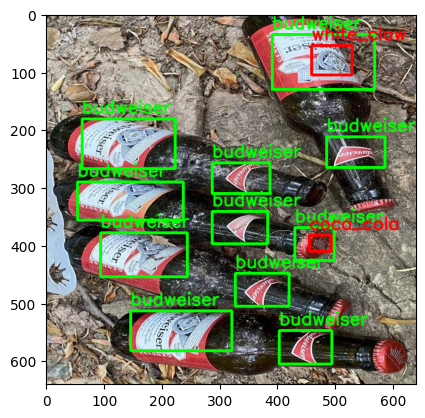

In [21]:
#Test cell to test boxes matching on one image

thr = 0.15
#im_file = 'IMG_6420_jpg.rf.7d5c73f52763c52e8df0e3cdb7acb41e.jpg'
#im_name  = im_file.split('_jpg')[0]

im_name = '2021_05_16_IMG_7295'
im_file = [file for file in os.listdir(image_path) if im_name in file][0]

# Get the data slices for this image
true_labels_df = test_labels_df[test_labels_df['im_name'] == im_name].copy()
pred_labels_df = boxes_df_read[boxes_df_read['im_name']==im_name].copy()

# Convert the YOLO notation to coordinates
# Get the dimentions of the original image
file_path = os.path.join(image_path, im_file)
im_orig = cv2.imread(file_path)
im_h, im_w = im_orig.shape[:2]
# Recalculate coordinates
true_labels_df['xmin_coord'] = (im_w * true_labels_df['cent_x'] - 0.5*im_w*true_labels_df['box_w']).astype(int)
true_labels_df['xmax_coord'] = (im_w * true_labels_df['cent_x'] + 0.5*im_w*true_labels_df['box_w']).astype(int)
true_labels_df['ymin_coord'] = (im_h * true_labels_df['cent_y'] - 0.5*im_h*true_labels_df['box_h']).astype(int)
true_labels_df['ymax_coord'] = (im_h * true_labels_df['cent_y'] + 0.5*im_h*true_labels_df['box_h']).astype(int)

# Go over each true lable in this image
for i in range(len(true_labels_df)): 
	dict_IoU = {-1:-1} # make a dict of pred_box_id:IoU pairs for this true box
	# Construct a box for the true box
	boxA = true_labels_df['xmin_coord'].iloc[i], true_labels_df['ymin_coord'].iloc[i], \
		true_labels_df['xmax_coord'].iloc[i], true_labels_df['ymax_coord'].iloc[i] 

	# Go over every predicted box
	for j in range(len(pred_labels_df)): # calculate IoU between true and predicted box
		boxB = pred_labels_df['xmin_coord'].iloc[j], pred_labels_df['ymin_coord'].iloc[j],\
			pred_labels_df['xmax_coord'].iloc[j], pred_labels_df['ymax_coord'].iloc[j] 
		dict_IoU[pred_labels_df['box_id'].iloc[j]] = bb_iou(boxA, boxB)

	# Find the ID of the box that overlaps the most
	max_box_id = max(dict_IoU, key=dict_IoU.get)
	# If its IoU is above threshold
	# update the box ID of predicted box to match ID of the true box
	if dict_IoU[max_box_id] > thr:
		idx = pred_labels_df[pred_labels_df['box_id'] == max_box_id].index
		pred_labels_df.at[idx[0], 'box_id'] =  true_labels_df['box_id'].iloc[i]

# Collect both true and predicted boxes in the image
image_boxes_df = pd.merge(true_labels_df, pred_labels_df, on='box_id', how='outer')

# Make a column with image name, given that pred or true can be empty
image_boxes_df['im_name'] = image_boxes_df['im_name_x'].fillna(image_boxes_df['im_name_y'])

# Calcualte total confidence for the predictions
# No precitions is the same as predicting background, 
# mAP does not include it background, so put 1, whatever
image_boxes_df['conf'] = image_boxes_df['conf'].fillna(1)

# No label means background
image_boxes_df[['predicted', 'true']] = image_boxes_df[['predicted', 'true']].fillna('background')

# Get only the columns we need
image_boxes_df = image_boxes_df[['im_name', 'conf', 'predicted', 'true', 'box_id']]

# Draw ground truth boxes:
# for each box, draw the box and label
for box_params in true_labels_df[['true', 'xmin_coord', 'ymin_coord', 'xmax_coord', 'ymax_coord']].values:
	lbl, x1, y1, x2, y2 = box_params
	color = (0,255,0)
	cv2.rectangle(im_orig, (x1,y1), (x2,y2), color, 3)
	cv2.putText(im_orig, lbl, (x1,y1-10), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2, cv2.LINE_AA)

# Draw predicted boxes 
for box_params in pred_labels_df[['predicted', 'xmin_coord', 'ymin_coord', 'xmax_coord', 'ymax_coord']].values:
	lbl, x1, y1, x2, y2 = box_params
	color = (0,0,255)
	cv2.rectangle(im_orig, (x1,y1), (x2,y2), color, 3)
	cv2.putText(im_orig, lbl, (x1,y1-10), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2, cv2.LINE_AA)

#Show the picture
plt.imshow(cv2.cvtColor(im_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
# Go over the dataset and corrrelate bounding boxes from ground truth and predictions
thr = 0.15
boxes_df = pd.DataFrame(columns = ['im_name', 'conf', 'predicted', 'true', 'box_id'])
for im_file in os.listdir(image_path):
	print('---', im_file, '---')
	im_name  = im_file.split('_jpg')[0]

	# Get the data slices for this image
	true_labels_df = test_labels_df[test_labels_df['im_name'] == im_name].copy()
	pred_labels_df = boxes_df_read[boxes_df_read['im_name']==im_name].copy()

	# Convert the YOLO notation to coordinates
	# Get the dimentions of the original image
	file_path = os.path.join(image_path, im_file)
	im_orig = cv2.imread(file_path)
	im_h, im_w = im_orig.shape[:2]
	# Recalculate coordinates
	true_labels_df['xmin_coord'] = (im_w * true_labels_df['cent_x'] - 0.5*im_w*true_labels_df['box_w']).astype(int)
	true_labels_df['xmax_coord'] = (im_w * true_labels_df['cent_x'] + 0.5*im_w*true_labels_df['box_w']).astype(int)
	true_labels_df['ymin_coord'] = (im_h * true_labels_df['cent_y'] - 0.5*im_h*true_labels_df['box_h']).astype(int)
	true_labels_df['ymax_coord'] = (im_h * true_labels_df['cent_y'] + 0.5*im_h*true_labels_df['box_h']).astype(int)

	# Go over each true lable in this image
	for i in range(len(true_labels_df)): 
		dict_IoU = {-1:-1} # make a dict of pred_box_id:IoU pairs for this true box
		# Construct a box for the true box
		boxA = true_labels_df['xmin_coord'].iloc[i], true_labels_df['ymin_coord'].iloc[i], \
			true_labels_df['xmax_coord'].iloc[i], true_labels_df['ymax_coord'].iloc[i] 

		# Go over every predicted box
		for j in range(len(pred_labels_df)): # calculate IoU between true and predicted box
			boxB = pred_labels_df['xmin_coord'].iloc[j], pred_labels_df['ymin_coord'].iloc[j],\
				pred_labels_df['xmax_coord'].iloc[j], pred_labels_df['ymax_coord'].iloc[j] 
			dict_IoU[pred_labels_df['box_id'].iloc[j]] = bb_iou(boxA, boxB)

		# Find the ID of the box that overlaps the most
		max_box_id = max(dict_IoU, key=dict_IoU.get)
		# If its IoU is above threshold
		# update the box ID of predicted box to match ID of the true box
		if dict_IoU[max_box_id] > thr:
			idx = pred_labels_df[pred_labels_df['box_id'] == max_box_id].index
			pred_labels_df.at[idx[0], 'box_id'] =  true_labels_df['box_id'].iloc[i]

	# Collect both true and predicted boxes in the image
	image_boxes_df = pd.merge(true_labels_df, pred_labels_df, on='box_id', how='outer')

	# Make a column with image name, given that pred or true can be empty
	image_boxes_df['im_name'] = image_boxes_df['im_name_x'].fillna(image_boxes_df['im_name_y'])

	# Calcualte total confidence for the predictions
	# No precitions is the same as predicting background, 
	# mAP does not include it background, so put 1, whatever
	image_boxes_df['conf'] = image_boxes_df['conf'].astype(float).fillna(1.0)

	# No label means background
	image_boxes_df[['predicted', 'true']] = image_boxes_df[['predicted', 'true']].fillna('background')

	# Get only the columns we need
	image_boxes_df = image_boxes_df[['im_name', 'conf', 'predicted', 'true', 'box_id']]
	boxes_df = pd.concat([boxes_df,image_boxes_df],ignore_index=True)
boxes_df.head(3)

In [17]:
def isTP(row, brand):
    if (row['true'] == brand) & (row['predicted'] == brand):
        return 1
    else:
        return 0
    
def isFP(row, brand):
    if (row['true'] != brand) & (row['predicted'] == brand):
        return 1
    else:
        return 0
    
def isFN(row, brand):
    if (row['true'] == brand) & (row['predicted'] != 'background'):
        return 1
    else:
        return 0

In [18]:
# Calcualte mAP for this threshold
APs = {}

# Get the number of boxes per each label in the test set
test_lbl_count = test_labels_df.groupby('true')['im_name'].count().sort_values(ascending=False)

# Evaluate AP for every brand that is in the test set
# We do not evaluate precision for brands that are not in test set,
#  these are hallucianations and precision is not defined for them.
for brand in ['budweiser']:
    # Select only boxes pertaining to this brand
    brand_df = boxes_df[boxes_df['predicted'].str.contains(brand, case=False) | 
                            boxes_df['true'].str.contains(brand, case=False)].copy()
    # Figure out if each box is TP or FP, do not care for FN or TN
    brand_df['FP'] = brand_df.apply(lambda x: isFP(x, brand), axis=1)
    brand_df['TP'] = brand_df.apply(lambda x: isTP(x, brand), axis=1)
    brand_df['FN'] = brand_df.apply(lambda x: isFN(x, brand), axis=1)

    # Sort the boxes by confidence
    brand_df.sort_values('conf', ascending=False, inplace=True)
    brand_df.reset_index(drop=True, inplace=True)

    # Figure out which record is TP and which is FP
    # We do not care for FN and TN for mAP metric
    # Then compute precision and recall for every level of confidence
    rec_lvls = np.linspace(0, 1, 11)
    for i in range(len(brand_df)):
        TP = brand_df.loc[:i, 'TP'].sum()
        FP = brand_df.loc[:i, 'FP'].sum()
        try:
            count = test_lbl_count[brand]
        except KeyError:
            count = 0
        if (TP+FP) >0:
            brand_df.loc[i, 'prec'] = TP/float(TP+FP)
        else:
            brand_df.loc[i, 'prec'] = 0
        brand_df.loc[i, 'rec'] = TP/float(count)

    # Compute AP using COCO 11-Point Interpolation:
    # take 11 evenly spaced recall levels
    # compute area under Prec-Rec curve interpolated at these levels.
    prec_rec_df = pd.DataFrame(columns = ['rec', 'prec'])
    for i, lvl in enumerate(rec_lvls):
        if len(brand_df[brand_df['rec']>= lvl]['prec'])>0:
            max_prec = brand_df[brand_df['rec']>= lvl]['prec'].max()
        else:
            max_prec = 0
        prec_rec_df.loc[i] = [lvl, max_prec]
    prec_rec_df.fillna(0.0, inplace=True)
    AP = prec_rec_df['prec'].mean()
    APs[brand] = AP


mAP = np.mean(list(APs.values()))
mAP

0.20959595959595959

In [19]:
brand_df.groupby('im_name').aggregate({'TP':sum, 'FP':sum, 'FN':sum}).sort_values('TP')

/tmp/ipykernel_193691/380372886.py:1: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  brand_df.groupby('im_name').aggregate({'TP':sum, 'FP':sum, 'FN':sum}).sort_values('TP')
/tmp/ipykernel_193691/380372886.py:1: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  brand_df.groupby('im_name').aggregate({'TP':sum, 'FP':sum, 'FN':sum}).sort_values('TP')


,TP,FP,FN
im_name,,,
2018_08_13_swBTkaYEa7q560s2fmVvjNFeNmlCvX9Y1UB2LdqV,0,0,0
2019_03_08_a14VERRZiS3D31Cg0ytZc1HV0cjy1wXXifrYfUSZ,0,0,1
2019_03_18_AU1X8hL66D2T0Z3biI0zqc14GoQozZdKCITTf6TB,0,0,0
2021_05_16_IMG_7295,0,0,2
2022_04_27_hiuJwHtbypbK157mSzwOV9InmsLRowLbwCnpP33e,0,1,0
2019_06_11_clw6P2bMGc28DQAufhhCvZJew4F11F3GxGhuJURf,1,0,1
2021_12_27_gPCvrnwFeqYHQIVWBaIdkmFxKBvUSa5zx9trS3tQ,1,2,2
2022_05_28_vMlIYI6O2UMhdxytWLz9JVDeTOHRSpL45mZSyXDL,1,1,1
2021_12_27_7mtFIQqSHDfCcJOybT61Cb5a1mbdTG915B8IQ9PK,2,0,2


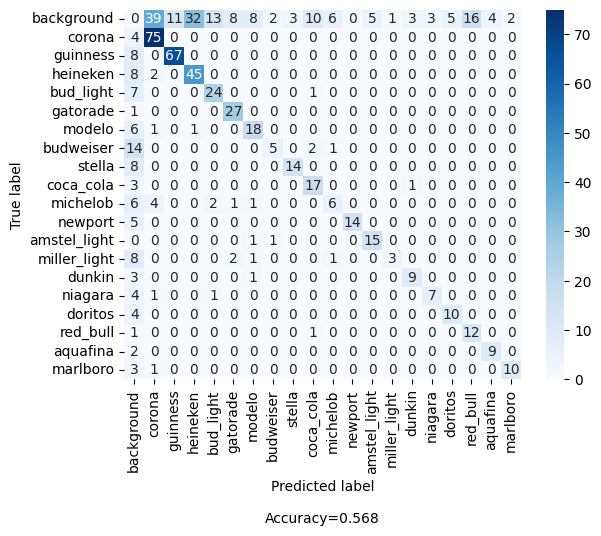

In [12]:
cf_matrix_df = boxes_df.copy()
test_lbl_count = boxes_df.groupby('true')['im_name'].count().sort_values(ascending=False)
cf_matrix_df['counts'] = cf_matrix_df['true'].apply(lambda x: test_lbl_count[x] )
cf_matrix_df.sort_values('counts', ascending=False, inplace=True)
sorted_dict = sorted(test_lbl_count.items(), key=lambda x: x[1], reverse=True)
labels = [item[0] for item in sorted_dict][:20]
cf_matrix = confusion_matrix(y_true = boxes_df['true'], y_pred = boxes_df['predicted'], labels = labels)

#cf_matrix[cf_matrix>30] = 30

make_confusion_matrix(cf_matrix, categories = labels, count = True, percent= False, cmap='Blues')